
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       28
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       18

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality c

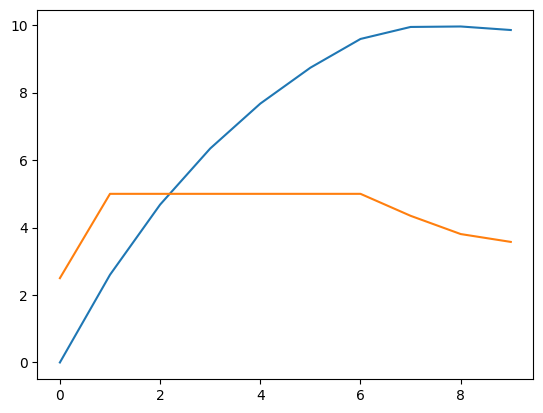

In [1]:
import casadi as ca
import matplotlib.pyplot as plt

# Create an Opti instance
opti = ca.Opti()

#=========== Parameters of the ARX model 
a = 0.8
b  = 0.5
c = 0.1

#=========== Desired value of y 
yd = opti.parameter()
measured_outflow = opti.parameter()
measured_speed =  opti.parameter()

yd = 10
measured_outflow = 0
measured_speed = 100

#=========== Define the Horizon
N = 10  

#=========== Declare Symbolic Variables (SISO but can be extended to MIMO or MISO)
outflow = opti.variable(N)
u = opti.variable(N)

#=========== Objective function
# Minimize the deviation of y from yd and control effort
objective = 0
for t in range(1, N):
    objective += 5*(outflow[t] - yd)**2 + 0.1*u[t]**2  

opti.minimize(objective)

# ARX model constraints
for t in range(1, N):
    opti.subject_to(outflow[t] == a * outflow[t-1] + b * u[t] + c)

# Additional constraints (e.g., on control input)
for t in range(N):
    opti.subject_to(u[t] >= 0)  # Lower bound on control input
    opti.subject_to(u[t] <= 5)   # Upper bound on control input

# Initial conditions
opti.subject_to(outflow[0] == measured_outflow)  # Initial value of y, read from sensor
#opti.subject_to(u[0] == measured_speed)  # Initial value of u, read from sensor

# Solver options
opts = {
    "qpsol": "ipopt",
    #"convexify_strategy": "regularize",
    "print_time": 0,
    "print_iteration": 0,
    "print_header": 0,
    "verbose": False,
    "error_on_fail": False
}

#opti.solver("sqpmethod", opts)
opti.solver('ipopt')

sol = opti.solve();   # actual solve


plt.plot(sol.value(outflow))
plt.plot(sol.value(u))
plt.show()


In [2]:
name = 'func'
func = opti.to_function(name, [yd, measured_outflow, measured_speed], [u, outflow], ['y_ref','outflow_lag', 'speed_lag'],['opt_u','outflow_preds'])
#name the inputs and outputs of the function


-------------------------------------------
This is casadi::QRQP
Number of variables:                              20
Number of constraints:                            30
Number of nonzeros in H:                          18
Number of nonzeros in A:                          48
Number of nonzeros in KKT:                       146
Number of nonzeros in QR(V):                      99
Number of nonzeros in QR(R):                     162


In [3]:
solution = func(y_ref = 1, outflow_lag= 2, speed_lag=3)

 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     1         0         2    49        10     1   3.3e-16    30         0  
    1     0         0         2    49        10     1      0.41    11         1  Enforced lbz for regularity, i=29
    2     0       -45       1.3    31   3.4e-15     5      0.15    31         1  Added lbz to reduce |pr|, i=31
    3     0       -42      0.84    33   1.8e-15     1     0.085    31         1  Added lbz to reduce |pr|, i=33
    4     0       -41      0.49    35   1.1e-14     1     0.064    31         1  Added lbz to reduce |pr|, i=35
    5     0       -41       0.2    37   4.9e-15     2     0.053    31         1  Added lbz to reduce |pr|, i=37
    6     0       -41   5.3e-16    21   3.6e-15     1     0.053    31         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations


In [4]:
import numpy as np 
opt_rpm = np.array(solution["opt_u"]).flatten()
opt_outflow_prediction = np.array(solution["outflow_preds"]).flatten()

In [5]:
import os 
import os

os.chdir('c_code_generated')
opts = dict(main=True, \
            mex=False)
            # Move into the generated code directory
func.generate('edge_mpc.c',opts)
return_value = os.system('gcc -fPIC -shared edge_mpc.c -o edge_mpc.so -lm')
if return_value == 0:
    print("Code generation successful")
else:
    print("Code generation failed")


Code generation successful


In [6]:
f = ca.external('func', 'edge_mpc.so')

In [12]:
solution_c_gen = f(y_ref = 1, outflow_lag= 2, speed_lag=3)

In [13]:
import numpy as np 
opt_rpm = np.array(solution_c_gen["opt_u"]).flatten()
opt_outflow_prediction = np.array(solution_c_gen["outflow_preds"]).flatten()

In [14]:
print(opt_rpm)
print(opt_outflow_prediction)


[0.         0.         0.         0.         0.         0.02693768
 0.18957328 0.1987701  0.19868824 0.1880446 ]
[2.         1.7        1.46       1.268      1.1144     1.00498884
 0.99877771 0.99840722 0.9980699  0.99247822]
